# Model TCNN Time Series for COVID : Training

This notebook explore from official "Sante Publique France" data about COVID-19 in France


These data have 4-days time delay.

The time series model is created and trained to predict future 7 next days (output) based on 14 past last days (input).


**Input Features are daily data of:**

- Min/Max Temperatures
- Min/Max Humidities
- nb. Confirmed cases
- nb. Tested cases
- Day of the week
- Mean Age of Tested cases
- Mean Age of Confirmed cases

**DATA sources:**

Tested / Confirmed cases: https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19

Météo France : https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm

**GitHub:** https://github.com/jeugregg/coronavirusModel

## import

In [19]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model
from tcn import TCN, tcn_full_summary

from sklearn.metrics import mean_absolute_error

# projects libs
from my_helpers.data_plots import get_data_pos
from my_helpers.data_plots import load_data_pos
from my_helpers.data_plots import get_old_data_pos
from my_helpers.data_plots import load_old_data_pos
from my_helpers.data_plots import PATH_DF_GOUV_FR_OLD
from my_helpers.model import multivariate_data
from my_helpers.model import prepare_to_lambda
from my_helpers.model import retrieve_from_lambda
from my_helpers.model import create_list_past_hist
from my_helpers.model import predict_list

In [20]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [21]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [22]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [23]:
tf.test.is_built_with_cuda()

True

In [24]:
tf.test.is_built_with_gpu_support()

True

In [25]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 13162102921904392330,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 7017170208
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7735031895886997803
 physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:00:03.0, compute capability: 6.1"]

## Definitions

In [26]:
mode_train = True

In [27]:
PATH_TO_SAVE_DATA = "."
PATH_DF_POS_FR = PATH_TO_SAVE_DATA + '/' + 'df_pos_fr.csv'
PATH_DF_TEST_FR = PATH_TO_SAVE_DATA + '/' + 'df_test_fr.csv'
PATH_JSON_METEO_FR = PATH_TO_SAVE_DATA + '/' + 'data_meteo_fr.json'
PATH_DF_FEAT_FR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_GEO_DEP_FR = PATH_TO_SAVE_DATA + '/sources/geofrance/' + 'departments.csv'
PATH_MDL_MULTI_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_fr_tcn"
PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
    'serverless/tensorflow_lite_on_aws_lambda'
PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
    "converted_model.tflite"
PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020

URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
PAST_HISTORY = 14 # days used to predict next values in future
FUTURE_TARGET = 7 # nb predict days later
STEP = 1

# plot
nb_period_plot = 15
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

##  Helper functions

In [28]:
# FOR MODEL
"""def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    '''
    Create dataset for training : create each samples (timeseries data)
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)"""

# FOR DATES
def add_days(str_date_0, nb_days_CV):
    '''
    add days to string dates
    '''
    date_format = "%Y-%m-%d"
    date_last = datetime.datetime.strptime(str_date_0, date_format)
    date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def generate_list_dates(str_date_0, str_date_1, step=1, date_format=None):
    if date_format is None:
        date_format = "%Y-%m-%d"
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    if delta.days > 0:
        return [(date_0 + \
                 datetime.timedelta(days=I)).strftime(date_format) \
               for I in range(1, delta.days+1, step)]
    else:
        return None


# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
# save file before update
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))

## Retrieve data

In [29]:
get_data_pos()
df_feat_fr = load_data_pos()

No new data meteo


## Retrieve old data

In [30]:
if not os.path.isfile(PATH_DF_GOUV_FR_OLD):
    get_old_data_pos()
    
df_feat_fr_old = load_old_data_pos()

df_feat_fr_old

date       T_min       T_max      H_min      H_max  pos  \
date                                                                        
2020-03-10  2020-03-10  283.708333  289.736667  70.666667  90.416667    8   
2020-03-11  2020-03-11  285.335000  291.913333  66.183333  91.383333   16   
2020-03-12  2020-03-12  284.048333  290.268333  63.866667  89.883333   33   
2020-03-13  2020-03-13  282.503333  289.148333  56.150000  88.500000   61   
2020-03-14  2020-03-14  282.253333  289.338333  62.116667  88.683333   54   
...                ...         ...         ...        ...        ...  ...   
2020-05-08  2020-05-08  287.051695  296.029661  53.568966  86.327586   15   
2020-05-09  2020-05-09  288.019492  295.305932  60.448276  87.448276   29   
2020-05-10  2020-05-10  288.058621  293.532759  68.228070  92.649123   17   
2020-05-11  2020-05-11  284.517797  290.512712  67.310345  90.396552  210   
2020-05-12  2020-05-12  283.870000  289.811667  61.932203  86.322034  168   

              age_pos   test   age_test  day_num  nb_cases  
date                                                        
2020-03-10  66.625000     79  50.696203        2    101343  
2020-03-11  44.875000    108  45.587963        3    101359  
2020-03-12  58.681818    156  49.362179        4    101392  
2020-03-13  49.073770    350  44.335714        5    101453  
2020-03-14  51.222222    167  48.664671        6    101507  
...               ...    ...        ...      ...       ...  
2020-05-08  65.366667    448  59.638393        5    139803  
2020-05-09  45.431034   1513  52.868804        6    139832  
2020-05-10  61.676471    293  60.738908        0    139849  
2020-05-11  63.357143  10339  53.020892        1    140059  
2020-05-12  63.345238  10567  51.926706        2    140227  

[64 rows x 11 columns]

## Train/Test split

In [31]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-05-03  281.508333  2021-05-03  291.938333  46.450000  86.866667     0.0   
2021-05-04  284.020000  2021-05-04  290.883333  55.266667  85.683333     0.0   
2021-05-05  284.170000  2021-05-05  290.341667  53.066667  86.883333     0.0   
2021-05-06  283.796667  2021-05-06  290.420000  63.350000  90.016667     0.0   
2021-05-07  284.735000  2021-05-07  291.736667  54.416667  88.750000     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-05-13    884  61.085973   39096  55.449279        3    141111        NaN   
2020-05-14    980  60.456122   42021  54.836820        4    142091        NaN   
2020-05-15   1021  60.042116   47694  54.388833        5    143112        NaN   
2020-05-16    292  60.085616   16541  54.488000        6    143404        NaN   
2020-05-17    139  61.568345    6612  58.282970        0    143543        NaN   
...           ...        ...     ...        ...      ...       ...        ...   
2021-05-03  32488  42.164245  479742  43.617855        1   5626704   338361.0   
2021-05-04  22842  41.566632  409480  40.603736        2   5649546   326092.0   
2021-05-05  19969  40.927488  357256  43.091884        3   5669515   313036.0   
2021-05-06  19120  40.429132  443036  38.192122        4   5688635   300542.0   
2021-05-07  19854  39.767906  498154  39.334949        5   5708489   288222.0   

                  Rt  rate_pos  
date                            
2020-05-13       NaN  2.261101  
2020-05-14       NaN  2.332167  
2020-05-15       NaN  2.140730  
2020-05-16       NaN  1.765310  
2020-05-17       NaN  2.102238  
...              ...       ...  
2021-05-03  0.682814  6.771973  
2021-05-04  0.693442  5.578294  
2021-05-05  0.682506  5.589549  
2021-05-06  0.670251  4.315676  
2021-05-07  0.658251  3.985515  

[360 rows x 15 columns]

In [32]:
if mode_train:
    # keep 25 Validation samples:
    TRAIN_SPLIT = df_feat_fr.shape[0] - (2 * FUTURE_TARGET)
    #TRAIN_SPLIT = 45
else:
    from my_helpers.model import TRAIN_SPLIT
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 346


In [33]:
df_feat_fr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_fr.shape[0])]
df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-05-03  281.508333  2021-05-03  291.938333  46.450000  86.866667     0.0   
2021-05-04  284.020000  2021-05-04  290.883333  55.266667  85.683333     0.0   
2021-05-05  284.170000  2021-05-05  290.341667  53.066667  86.883333     0.0   
2021-05-06  283.796667  2021-05-06  290.420000  63.350000  90.016667     0.0   
2021-05-07  284.735000  2021-05-07  291.736667  54.416667  88.750000     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-05-13    884  61.085973   39096  55.449279        3    141111        NaN   
2020-05-14    980  60.456122   42021  54.836820        4    142091        NaN   
2020-05-15   1021  60.042116   47694  54.388833        5    143112        NaN   
2020-05-16    292  60.085616   16541  54.488000        6    143404        NaN   
2020-05-17    139  61.568345    6612  58.282970        0    143543        NaN   
...           ...        ...     ...        ...      ...       ...        ...   
2021-05-03  32488  42.164245  479742  43.617855        1   5626704   338361.0   
2021-05-04  22842  41.566632  409480  40.603736        2   5649546   326092.0   
2021-05-05  19969  40.927488  357256  43.091884        3   5669515   313036.0   
2021-05-06  19120  40.429132  443036  38.192122        4   5688635   300542.0   
2021-05-07  19854  39.767906  498154  39.334949        5   5708489   288222.0   

                  Rt  rate_pos  train  
date                                   
2020-05-13       NaN  2.261101   True  
2020-05-14       NaN  2.332167   True  
2020-05-15       NaN  2.140730   True  
2020-05-16       NaN  1.765310   True  
2020-05-17       NaN  2.102238   True  
...              ...       ...    ...  
2021-05-03  0.682814  6.771973  False  
2021-05-04  0.693442  5.578294  False  
2021-05-05  0.682506  5.589549  False  
2021-05-06  0.670251  4.315676  False  
2021-05-07  0.658251  3.985515  False  

[360 rows x 16 columns]

## Exploration

Distribution of TRAIN / VALIDATION dataset :

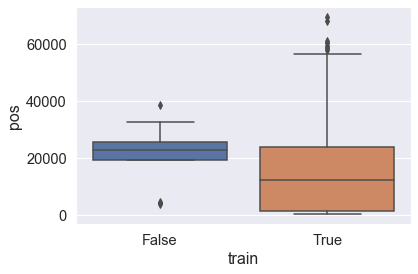

In [34]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_fr)

### age

#### First wave

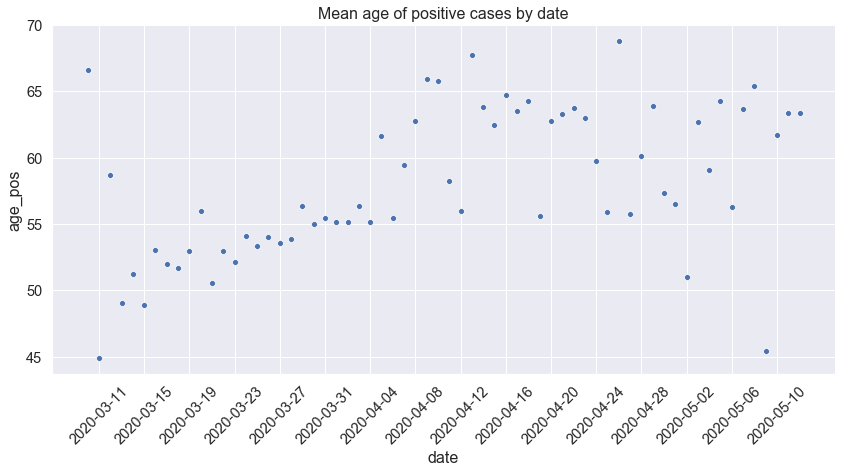

In [35]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr_old, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr_old["date"].min(), 
                    df_feat_fr_old["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

#### Second wave

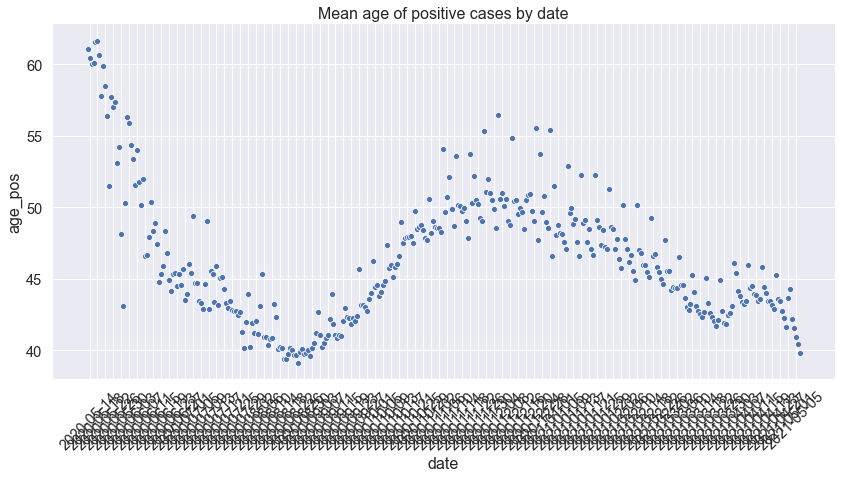

In [36]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr["date"].min(), 
                    df_feat_fr["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

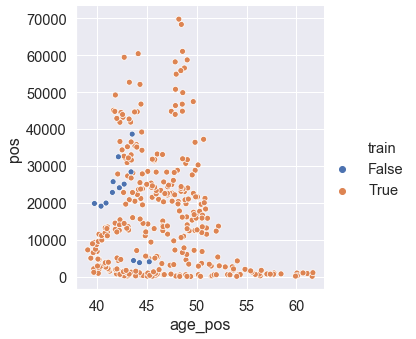

In [37]:
sns.relplot(x="age_pos", y="pos", hue="train", data=df_feat_fr);

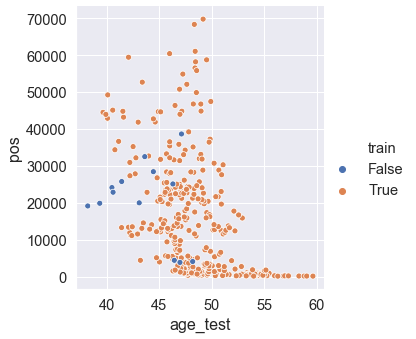

In [38]:
sns.relplot(x="age_test", y="pos", hue="train", data=df_feat_fr);

### Impact of day 

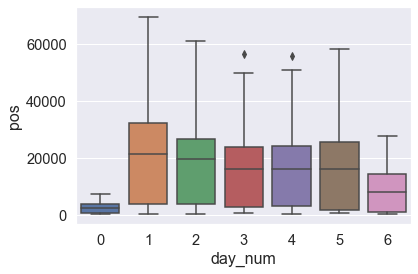

In [39]:
ax = sns.boxplot(x="day_num", y="pos", data=df_feat_fr)

=> It is not the reality. On weekend, a lot of local medical structures don't trace positive cases.

### Temperature impact

In [40]:
df_feat_fr["T_mean"] = 0.5 * (df_feat_fr["T_min"] + df_feat_fr["T_max"])

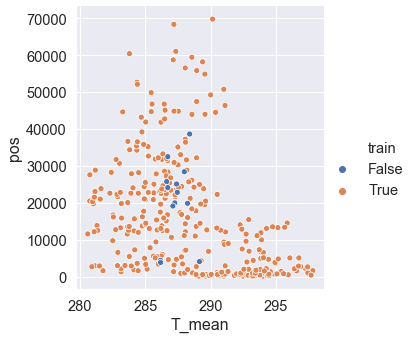

In [41]:
sns.relplot(x="T_mean", y="pos", hue="train", data=df_feat_fr);

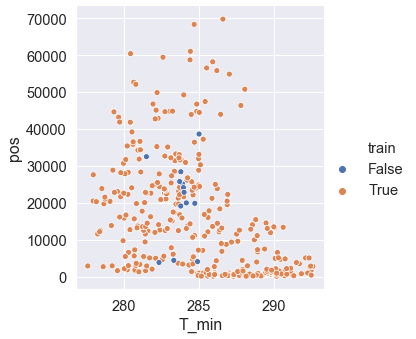

In [42]:
sns.relplot(x="T_min", y="pos", hue="train", data=df_feat_fr);

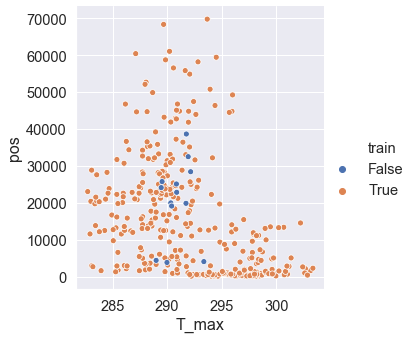

In [43]:
sns.relplot(x="T_max", y="pos", hue="train", data=df_feat_fr);

Impact of cold temperature :

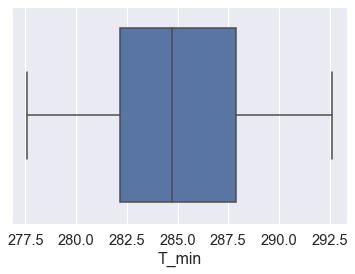

In [44]:
ax = sns.boxplot(x="T_min", data=df_feat_fr)

In [45]:
df_feat_fr["T_min"].mean()

285.02060354796333

In [46]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].mean()).value_counts()

True     193
False    167
Name: T_min, dtype: int64

In [47]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].median()).value_counts()

True     180
False    180
Name: T_min, dtype: int64

In [48]:
df_feat_fr["T_min"].median()

284.7255508474576

In [49]:
df_feat_fr["cold_min"] = df_feat_fr["T_min"] < df_feat_fr["T_min"].median()

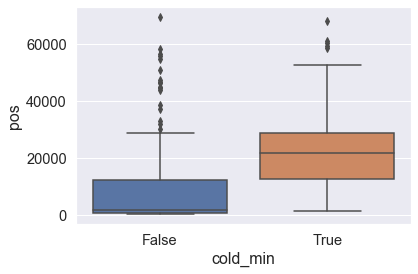

In [50]:
ax = sns.boxplot(x="cold_min", y="pos", data=df_feat_fr)

=> colder T min then more positive cases! but trend is not clear (more deviation with cold temperature)

Impact of T mean : 

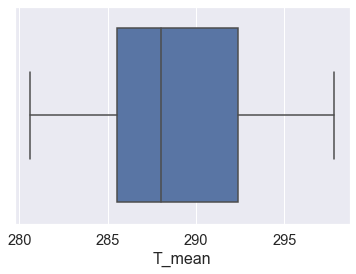

In [51]:
ax = sns.boxplot(x="T_mean", data=df_feat_fr)

In [52]:
df_feat_fr["T_mean"].median()

288.0330508474576

In [53]:
df_feat_fr["cold_mean"] = df_feat_fr["T_mean"] < df_feat_fr["T_mean"].median()

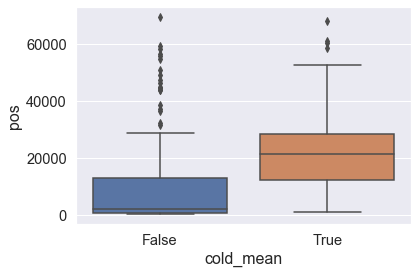

In [54]:
ax = sns.boxplot(x="cold_mean", y="pos", data=df_feat_fr)

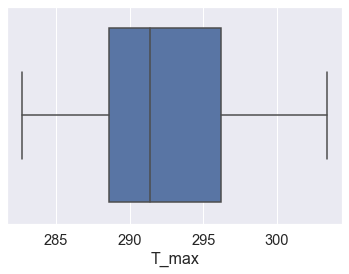

In [55]:
ax = sns.boxplot(x="T_max", data=df_feat_fr)

In [56]:
df_feat_fr["T_max"].median()

291.3658333333334

In [57]:
df_feat_fr["cold_max"] = df_feat_fr["T_max"] < df_feat_fr["T_max"].median()

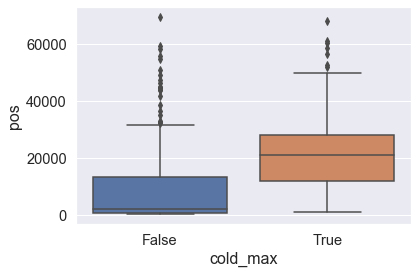

In [58]:
ax = sns.boxplot(x="cold_max", y="pos", data=df_feat_fr)

=> like T min

### Impact of Humidity

In [59]:
df_feat_fr["H_mean"] = 0.5 * (df_feat_fr["H_min"] + df_feat_fr["H_max"])

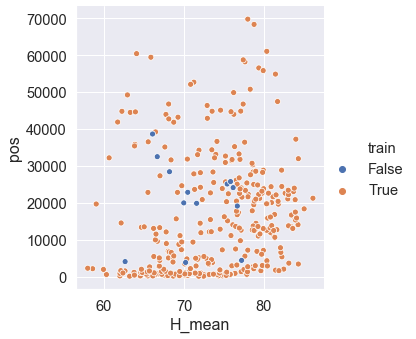

In [60]:
sns.relplot(x="H_mean", y="pos", hue="train", data=df_feat_fr);

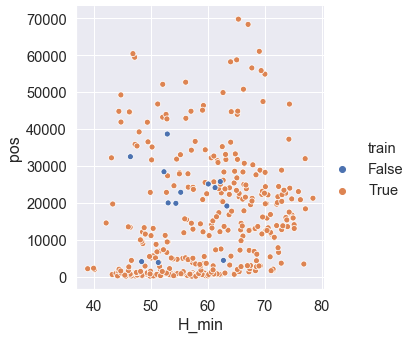

In [61]:
sns.relplot(x="H_min", y="pos", hue="train", data=df_feat_fr);

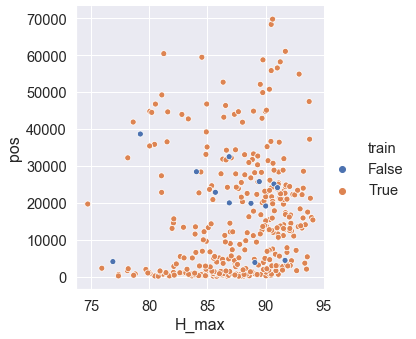

In [62]:
sns.relplot(x="H_max", y="pos", hue="train", data=df_feat_fr);

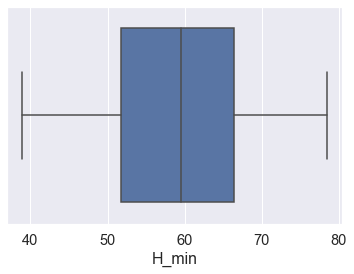

In [63]:
ax = sns.boxplot(x="H_min", data=df_feat_fr)

In [64]:
df_feat_fr["H_min"].median()

59.55

In [65]:
df_feat_fr["dry_min"] = df_feat_fr["H_min"] < df_feat_fr["H_min"].median()

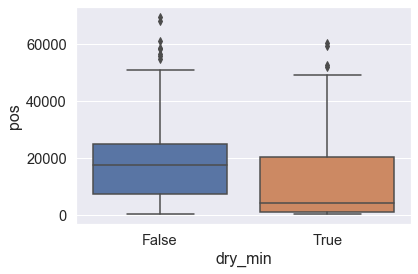

In [66]:
ax = sns.boxplot(x="dry_min", y="pos", data=df_feat_fr)

=> more DRY, less positive cases

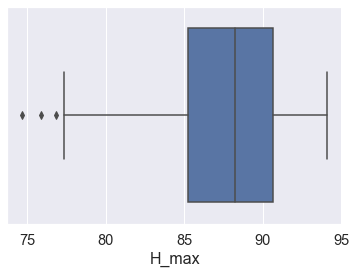

In [67]:
ax = sns.boxplot(x="H_max", data=df_feat_fr)

In [68]:
df_feat_fr["H_max"].median()

88.25240112994351

In [69]:
df_feat_fr["dry_max"] = df_feat_fr["H_max"] < df_feat_fr["H_max"].median()

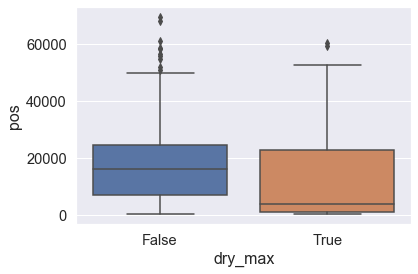

In [70]:
ax = sns.boxplot(x="dry_max", y="pos", data=df_feat_fr)

=> => Same than H min

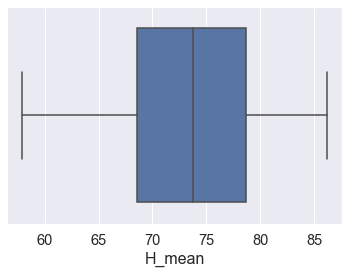

In [71]:
ax = sns.boxplot(x="H_mean", data=df_feat_fr)

In [72]:
df_feat_fr["H_mean"].median()

73.70899122807018

In [73]:
df_feat_fr["dry_mean"] = df_feat_fr["H_mean"] < df_feat_fr["H_mean"].median()

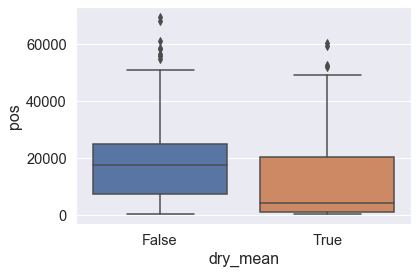

In [74]:
ax = sns.boxplot(x="dry_mean", y="pos", data=df_feat_fr)

=> Same H min

### Seasonality impact

In [75]:
df_feat_fr["month"] = df_feat_fr["date"].astype(np.datetime64).dt.month

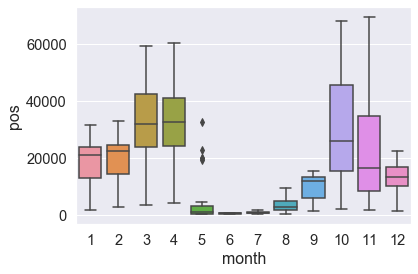

In [76]:
ax = sns.boxplot(x="month", y="pos", data=df_feat_fr)

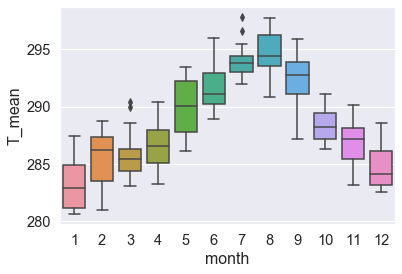

In [77]:
ax = sns.boxplot(x="month", y="T_mean", data=df_feat_fr)

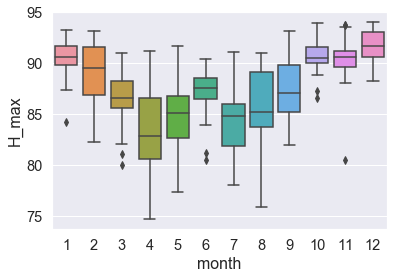

In [78]:
ax = sns.boxplot(x="month", y="H_max", data=df_feat_fr)

In [79]:
pt_month = df_feat_fr.pivot_table(values=["pos"],
                           index="month", aggfunc=np.sum)
pt_month

pos
month        
1      559594
2      558554
3      952060
4      923747
5      134355
6       14895
7       24768
8      105842
9      293378
10     932827
11     671646
12     396596

### Nb Tested

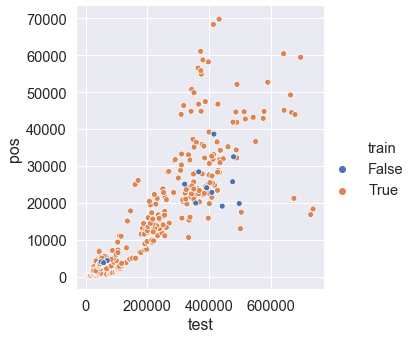

In [80]:
sns.relplot(x="test", y="pos", hue="train", data=df_feat_fr);

In [81]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested"))
# Edit the layout
fig.update_layout(title='COVID-19 Tested  (France)',
                   yaxis_title='nb Tested')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

In [82]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=100*df_feat_fr_old["pos"] / df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=100*df_feat_fr["pos"] / df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate"))
# Edit the layout
fig.update_layout(title='COVID-19 Positive rate  (France)',
                   yaxis_title='pos. rate [%]')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

## Prepare features

In [83]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

In [84]:
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
features

T_min       T_max      H_min      H_max    pos    test  \
date                                                                      
2020-05-13  284.926667  290.505000  64.661017  88.135593    884   39096   
2020-05-14  285.050000  290.963333  59.406780  84.847458    980   42021   
2020-05-15  285.308333  291.920000  57.372881  82.966102   1021   47694   
2020-05-16  284.956667  293.500000  53.741379  86.534483    292   16541   
2020-05-17  285.598333  294.446667  49.879310  85.500000    139    6612   
...                ...         ...        ...        ...    ...     ...   
2021-05-03  281.508333  291.938333  46.450000  86.866667  32488  479742   
2021-05-04  284.020000  290.883333  55.266667  85.683333  22842  409480   
2021-05-05  284.170000  290.341667  53.066667  86.883333  19969  357256   
2021-05-06  283.796667  290.420000  63.350000  90.016667  19120  443036   
2021-05-07  284.735000  291.736667  54.416667  88.750000  19854  498154   

            day_num    age_pos   age_test  
date                                       
2020-05-13        3  61.085973  55.449279  
2020-05-14        4  60.456122  54.836820  
2020-05-15        5  60.042116  54.388833  
2020-05-16        6  60.085616  54.488000  
2020-05-17        0  61.568345  58.282970  
...             ...        ...        ...  
2021-05-03        1  42.164245  43.617855  
2021-05-04        2  41.566632  40.603736  
2021-05-05        3  40.927488  43.091884  
2021-05-06        4  40.429132  38.192122  
2021-05-07        5  39.767906  39.334949  

[360 rows x 9 columns]

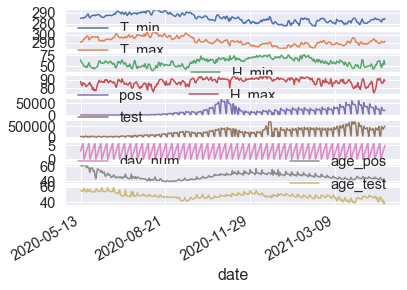

In [85]:
features.plot(subplots=True);

In [86]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [87]:
dataset.shape

(360, 9)

## Multi-step model

### Helper functions

In [88]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

### data 14D_to_7D

In [89]:
TRAIN_SPLIT

346

In [90]:
dataset.shape

(360, 9)

In [91]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [92]:
y_train_multi.shape

(332, 7)

In [93]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target future to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

332 Single window of past history : (14, 9)

 332 Target future to predict : (7,)


In [94]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 332
BUFFER_SIZE : 346

For validation : 
BATCH_SIZE_VAL : 7


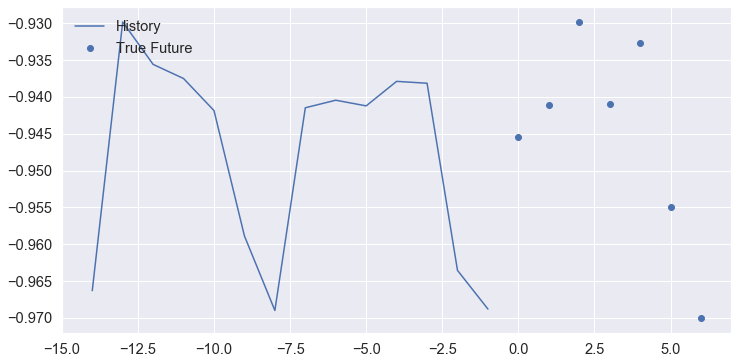

In [95]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Training

In [96]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 332
nb samples for validation : 7


In [97]:
x_train_multi.shape[-2:]

(14, 9)

In [98]:
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input, Model

from tcn import TCN, tcn_full_summary

batch_size, timesteps, input_dim = None, 20, 1


def get_x_y(size=1000):
    import numpy as np
    pos_indices = np.random.choice(size, size=int(size // 2), replace=False)
    x_train = np.zeros(shape=(size, timesteps, 1))
    y_train = np.zeros(shape=(size, 1))
    x_train[pos_indices, 0] = 1.0
    y_train[pos_indices, 0] = 1.0
    return x_train, y_train


i = Input(batch_shape=(batch_size, timesteps, input_dim))

o = TCN(return_sequences=False,
        dilations = [1, 2, 4])(i)  # The TCN layers are here.
o = Dense(1)(o)

m = Model(inputs=[i], outputs=[o])
m.compile(optimizer='adam', loss='mse')

tcn_full_summary(m, expand_residual_blocks=False)

x, y = get_x_y()
m.fit(x, y, epochs=10, validation_split=0.2)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
residual_block_0 (ResidualBl multiple                  8576      
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  16512     
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  16512     
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 41,665
Trainable params: 41,665
Non-trainable params: 0
_________________________________________________________

In [99]:
tcn_full_summary(m, expand_residual_blocks=True)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
matching_conv1D (Conv1D)     multiple                  128       
_________________________________________________________________
activation_3 (Activation)    multiple                  0         
_________________________________________________________________
conv1D_0 (Conv1D)            multiple                  192       
_________________________________________________________________
activation (Activation)      multiple                  0         
_________________________________________________________________
spatial_dropout1d (SpatialDr multiple                  0         
_________________________________________________________________
conv1D_1 (Conv1D)            multiple                  8256  

In [100]:



lr = 2e-2
decay = 1e-6 #1e-6
momentum = 0.9 # 0.9
nesterov = True # True
patience = 250 # 30

sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                              nesterov=nesterov)

in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

out_tcn = TCN(return_sequences=False,
        dilations = [1, 2, 4])(in_tcn)  # The TCN layers are here.
out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)

multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
multi_step_model.compile(optimizer=sgd_2, loss='mae')

tcn_full_summary(multi_step_model, expand_residual_blocks=False)


'''# create model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(Conv1D(filters=1, 
                            kernel_size=2, 
                            padding='causal',
                            dilation_rate=2, 
                            activation=None,
                            input_shape=x_train_multi.shape[-2:],
                        kernel_initializer=tf.keras.initializers.Constant(1.),
                           use_bias=False))'''

#x = Conv1D(filters, kernel_size, strides=1, padding='causal', data_format='channels_last',
#    dilation_rate=1, groups=1, activation=None)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 20, 1)]           0         
_________________________________________________________________
residual_block_0 (ResidualBl multiple                  8576      
_________________________________________________________________
residual_block_1 (ResidualBl multiple                  16512     
_________________________________________________________________
residual_block_2 (ResidualBl multiple                  16512     
_________________________________________________________________
lambda (Lambda)              multiple                  0         
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 455       
Total params: 42,055
Trainable params: 42,055
Non-trainable params: 0
_______________________________________________________

"# create model\nmulti_step_model = tf.keras.models.Sequential()\nmulti_step_model.add(Conv1D(filters=1, \n                            kernel_size=2, \n                            padding='causal',\n                            dilation_rate=2, \n                            activation=None,\n                            input_shape=x_train_multi.shape[-2:],\n                        kernel_initializer=tf.keras.initializers.Constant(1.),\n                           use_bias=False))"


 Run #0
Restoring model weights from the end of the best epoch.
Epoch 00653: early stopping
Run #0 : val_loss = 0.3609336316585541


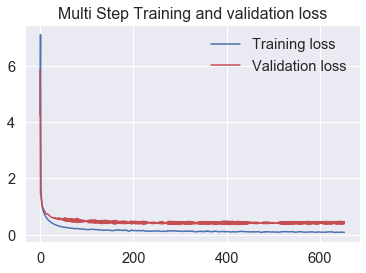

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #1
Restoring model weights from the end of the best epoch.
Epoch 00384: early stopping
Run #1 : val_loss = 0.4185609817504883

 Run #2
Restoring model weights from the end of the best epoch.
Epoch 00505: early stopping
Run #2 : val_loss = 0.445713073015213

 Run #3
Restoring model weights from the end of the best epoch.
Epoch 00650: early stopping
Run #3 : val_loss = 0.40828534960746765

 Run #4
Restoring model weights from the end of the best epoch.
Epoch 00844: early stopping
Run #4 : val_loss = 0.40113338828086853

 Run #5
Restoring model weights from the end of the best epoch.
Epoch 00877: early stopping
Run #5 : val_loss = 0.34058064222335815


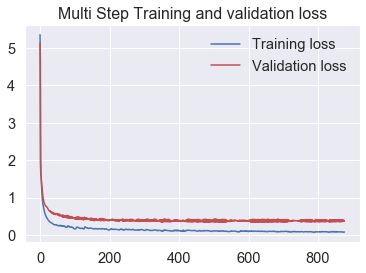

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #6
Restoring model weights from the end of the best epoch.
Epoch 00875: early stopping
Run #6 : val_loss = 0.331705242395401


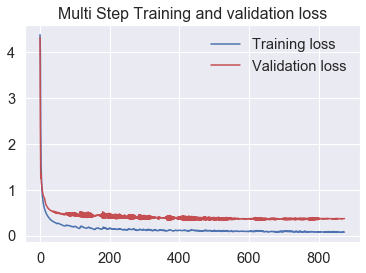

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #7
Restoring model weights from the end of the best epoch.
Epoch 00538: early stopping
Run #7 : val_loss = 0.4072270095348358

 Run #8
Restoring model weights from the end of the best epoch.
Epoch 00712: early stopping
Run #8 : val_loss = 0.3691573739051819

 Run #9
Restoring model weights from the end of the best epoch.
Epoch 00692: early stopping
Run #9 : val_loss = 0.43225526809692383

 Run #10
Restoring model weights from the end of the best epoch.
Epoch 00554: early stopping
Run #10 : val_loss = 0.5316051840782166

 Run #11
Restoring model weights from the end of the best epoch.
Epoch 00388: early stopping
Run #11 : val_loss = 0.3105178475379944


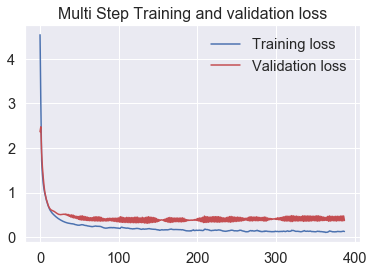

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #12
Restoring model weights from the end of the best epoch.
Epoch 00367: early stopping
Run #12 : val_loss = 0.4485299289226532

 Run #13
Restoring model weights from the end of the best epoch.
Epoch 00578: early stopping
Run #13 : val_loss = 0.45043110847473145

 Run #14
Restoring model weights from the end of the best epoch.
Epoch 00486: early stopping
Run #14 : val_loss = 0.37073037028312683

 Run #15
Restoring model weights from the end of the best epoch.
Epoch 00668: early stopping
Run #15 : val_loss = 0.4501388967037201

 Run #16
Restoring model weights from the end of the best epoch.
Epoch 00475: early stopping
Run #16 : val_loss = 0.3652014136314392

 Run #17
Restoring model weights from the end of the best epoch.
Epoch 00614: early stopping
Run #17 : val_loss = 0.3919979929924011

 Run #18
Restoring model weights from the end of the best epoch.
Epoch 00642: early stopping
Run #18 : val_loss = 0.4443734586238861

 Run #19
Restoring model weights from the end of the best e

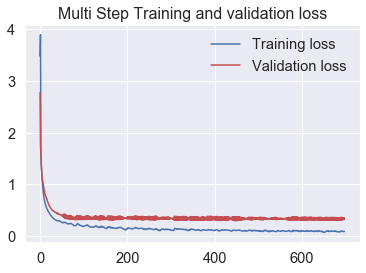

INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets


INFO:tensorflow:Assets written to: ./mdl_multi_step_pos_fr_tcn\assets



 Run #33
Restoring model weights from the end of the best epoch.
Epoch 00693: early stopping
Run #33 : val_loss = 0.3947325050830841

 Run #34
Restoring model weights from the end of the best epoch.
Epoch 00466: early stopping
Run #34 : val_loss = 0.4026188850402832

 Run #35
Restoring model weights from the end of the best epoch.
Epoch 00654: early stopping
Run #35 : val_loss = 0.33689191937446594

 Run #36
Restoring model weights from the end of the best epoch.
Epoch 00653: early stopping
Run #36 : val_loss = 0.360137939453125

 Run #37
Restoring model weights from the end of the best epoch.
Epoch 00355: early stopping
Run #37 : val_loss = 0.44925716519355774

 Run #38
Restoring model weights from the end of the best epoch.
Epoch 00794: early stopping
Run #38 : val_loss = 0.35414043068885803

 Run #39
Restoring model weights from the end of the best epoch.
Epoch 00956: early stopping
Run #39 : val_loss = 0.351895272731781

 Run #40
Restoring model weights from the end of the best ep

Restoring model weights from the end of the best epoch.
Epoch 00679: early stopping
Run #94 : val_loss = 0.41238638758659363

 Run #95
Restoring model weights from the end of the best epoch.
Epoch 00872: early stopping
Run #95 : val_loss = 0.3638675808906555

 Run #96
Restoring model weights from the end of the best epoch.
Epoch 00394: early stopping
Run #96 : val_loss = 0.4506698548793793

 Run #97
Restoring model weights from the end of the best epoch.
Epoch 00691: early stopping
Run #97 : val_loss = 0.3737123906612396

 Run #98
Restoring model weights from the end of the best epoch.
Epoch 00784: early stopping
Run #98 : val_loss = 0.4118376672267914

 Run #99
Restoring model weights from the end of the best epoch.
Epoch 00531: early stopping
Run #99 : val_loss = 0.3712773621082306
 
Final val_loss = 0.29574891924858093
Mean asbolute Error in people : 4617.854475479981
 
Wall time: 1h 23min 20s


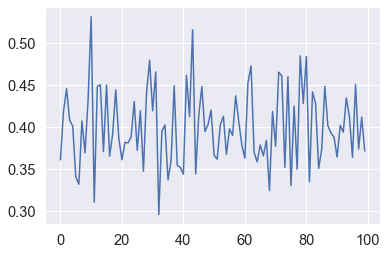

In [101]:
%%time

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    NB_TRY = 100 #700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000

    # Hyper-parameters
    # lr=6e-2, decay = 1e-6, momentum = 0.9,  nesterov = True, patience = 250
    # Final val_loss = 0.18278686702251434
    # Mean asbolute Error in people : 2587.2852865276022
    # Mac : CPU times: user 1h 50min 6s, sys: 43min 33s, total: 2h 33min 39s
    # Mac : Wall time: 1h 22min 11s
    #
    # 100 TRIES / EPOCHS 5000
    # lr = 2e-2 decay = 1e-6 momentum = 0.9 nesterov = True patience = 250
    # Final val_loss = 0.13554999232292175
    # Mean asbolute Error in people : 1901.908237664341
    # Wall time: 29min 44s GPU
    
    lr = 2e-2
    decay = 1e-6 #1e-6
    momentum = 0.9 # 0.9
    nesterov = True # True
    patience = 250 # 30

    batch_size, timesteps, input_dim = \
        None, x_train_multi.shape[1], x_train_multi.shape[2]

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                              nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        
        in_tcn = Input(batch_shape=(batch_size, timesteps, input_dim))

        out_tcn = TCN(return_sequences=False,
            dilations = [1, 2, 4])(in_tcn)  # The TCN layers are here.
        out_tcn = Dense(int(FUTURE_TARGET/STEP))(out_tcn)

        multi_step_model = Model(inputs=[in_tcn], outputs=[out_tcn])
        
        
        '''multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(features.shape[1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        multi_step_model.add(tf.keras.layers.BatchNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))'''
        # compile
        multi_step_model.compile(optimizer=sgd_2, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=EVALUATION_INTERVAL,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


### Eval

In [102]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr_tcn'

In [103]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

Wall time: 1.45 s


In [104]:
%%time
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)
print("Mean error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Mean nb cases  [nb of cases]: ", mean_val)
print("mean relative error [%]: ", 100*mean_error_val/mean_val)

Mean error  [nb of cases]:  4617.85451036819
Mean nb cases  [nb of cases]:  20627.20408163265
mean relative error [%]:  22.387205227101653
Wall time: 178 ms


In [105]:
multi_step_model.predict(x_val_multi)

array([[ 0.36386433,  0.31047395,  1.1380334 ,  1.2419962 ,  0.61825645,
         0.65489167,  0.532175  ],
       [-0.29629594,  1.6987824 ,  1.0567725 ,  0.48548162,  0.85642785,
         0.31463444, -0.32917532],
       [ 1.3077545 ,  0.559906  ,  0.19861883,  0.37043858, -0.07881251,
        -0.70042956, -0.7929926 ],
       [ 0.7319262 ,  1.069107  ,  0.6457792 ,  0.66159   , -0.08029783,
        -0.82667756,  1.2975578 ],
       [ 1.2038424 ,  0.58405125,  0.45055795, -0.24360693, -0.6885583 ,
         0.6620373 ,  0.6890353 ],
       [ 0.5483293 ,  0.29804114, -0.14246508, -0.63472617,  1.3707066 ,
         0.5283955 ,  0.35978562],
       [ 0.2476533 ,  0.4985707 , -0.8700524 ,  0.6167009 ,  0.9948405 ,
         0.8746616 ,  0.49191025]], dtype=float32)

In [106]:
y_val_multi_pred.shape[0]

7

In [107]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 9), (None, 7)), types: (tf.float64, tf.float64)>

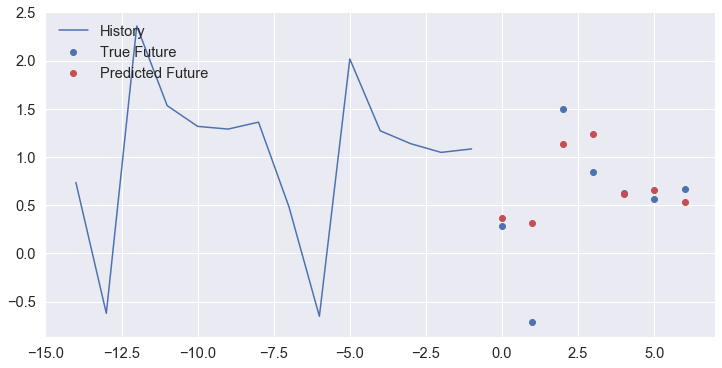

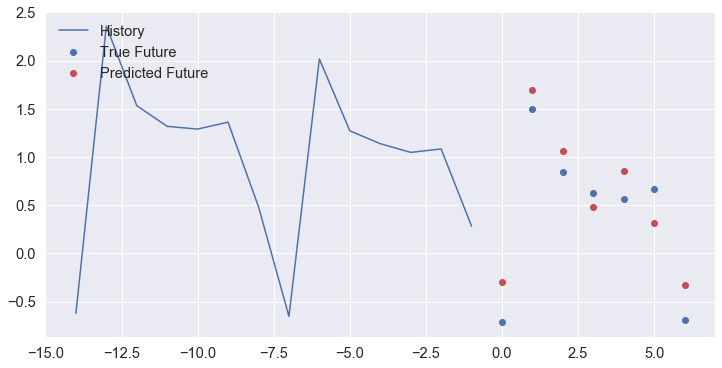

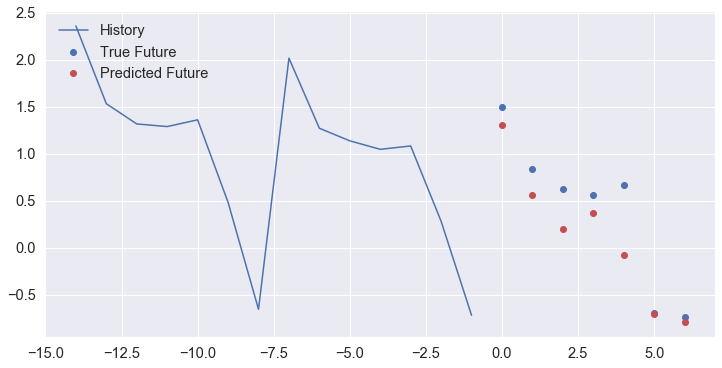

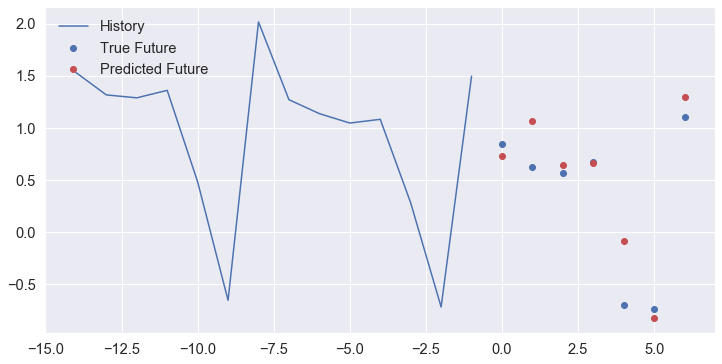

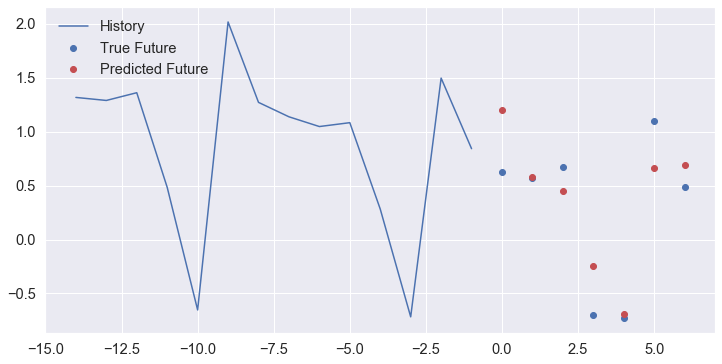

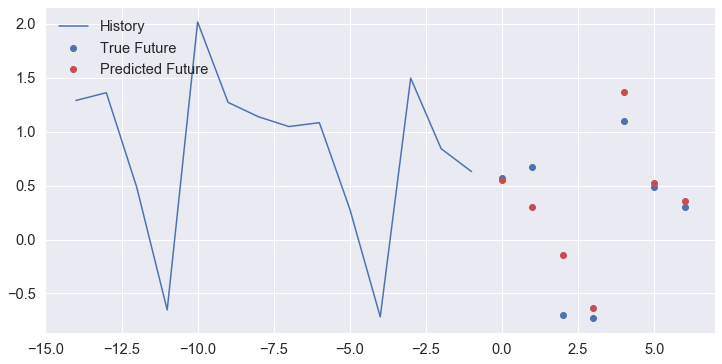

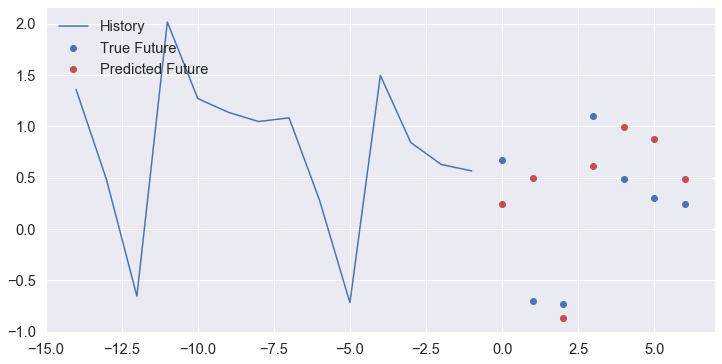

In [108]:
for x, y in val_data_multi.take(1):
    for I in range(y_val_multi_pred.shape[0]):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Future Prediction

In [109]:
nb_period_plot = 23
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

In [110]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr_tcn'

In [111]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)

In [112]:
TRAIN_SPLIT

346

In [113]:
# reload data
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]
# prepare features
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
# calculate mean & std 
#TRAIN_SPLIT = 93
# prepare dataset
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [114]:
df_feat_fr.shape

(360, 15)

In [115]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


Wall time: 165 ms


In [116]:
df_feat_fr.date.min()

'2020-05-13'

In [117]:
df_feat_fr.date.max()

'2021-05-07'

In [118]:
df_feat_fr.pos.std()

15490.921153675275

In [119]:
data_std[4]

15614.104312579457

In [120]:
str_date_0 = add_days(df_feat_fr.date.max(), -NB_DAY_PLOT)
str_date_0

'2020-11-27'

In [121]:
# last nth days
df_plot = df_feat_fr[df_feat_fr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_fr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

date    pos  nb_cases
2021-05-08  2021-05-08   8546   5717035
2021-05-09  2021-05-09   2104   5719139
2021-05-10  2021-05-10  29981   5749120
2021-05-11  2021-05-11  20466   5769586
2021-05-12  2021-05-12  31139   5800725
2021-05-13  2021-05-13  44735   5845460
2021-05-14  2021-05-14  24124   5869584

In [122]:
df_feat_fr.iloc[TRAIN_SPLIT]["date"]

'2021-04-24'

In [123]:
df_plot

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-11-27  283.640000  2020-11-27  289.690000  70.083333  90.733333     0.0   
2020-11-28  283.293333  2020-11-28  289.308333  68.600000  90.850000     0.0   
2020-11-29  281.455000  2020-11-29  287.461667  68.366667  90.900000     0.0   
2020-11-30  280.025000  2020-11-30  286.350000  70.383333  90.583333     0.0   
2020-12-01  281.608333  2020-12-01  286.676667  70.050000  92.233333     0.0   
...                ...         ...         ...        ...        ...     ...   
2021-05-03  281.508333  2021-05-03  291.938333  46.450000  86.866667     0.0   
2021-05-04  284.020000  2021-05-04  290.883333  55.266667  85.683333     0.0   
2021-05-05  284.170000  2021-05-05  290.341667  53.066667  86.883333     0.0   
2021-05-06  283.796667  2021-05-06  290.420000  63.350000  90.016667     0.0   
2021-05-07  284.735000  2021-05-07  291.736667  54.416667  88.750000     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  sum_cases  \
date                                                                            
2020-11-27  12456  49.265655  219938  50.879752        5   2171903   194020.0   
2020-11-28   6069  49.015653   99181  50.715692        6   2177972   189099.0   
2020-11-29   1604  55.319825   23731  55.020100        0   2179576   187989.0   
2020-11-30  15856  51.088610  238286  52.900611        1   2195432   173560.0   
2020-12-01  12373  51.958943  198862  52.199374        2   2207805   164309.0   
...           ...        ...     ...        ...      ...       ...        ...   
2021-05-03  32488  42.164245  479742  43.617855        1   5626704   338361.0   
2021-05-04  22842  41.566632  409480  40.603736        2   5649546   326092.0   
2021-05-05  19969  40.927488  357256  43.091884        3   5669515   313036.0   
2021-05-06  19120  40.429132  443036  38.192122        4   5688635   300542.0   
2021-05-07  19854  39.767906  498154  39.334949        5   5708489   288222.0   

                  Rt  rate_pos  
date                            
2020-11-27  0.404031  5.663414  
2020-11-28  0.406588  6.119116  
2020-11-29  0.407825  6.759091  
2020-11-30  0.411769  6.654189  
2020-12-01  0.427431  6.221903  
...              ...       ...  
2021-05-03  0.682814  6.771973  
2021-05-04  0.693442  5.578294  
2021-05-05  0.682506  5.589549  
2021-05-06  0.670251  4.315676  
2021-05-07  0.658251  3.985515  

[162 rows x 15 columns]

### Figure

In [124]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_fr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", secondary_y=True)

fig.show()


### Predict all past

In [125]:
nb_period_plot

23

In [126]:
dataset.shape

(360, 9)

In [127]:
%%time
# prepare list of past histories
list_x = create_list_past_hist(dataset, nb_period_plot=nb_period_plot)
# predict
y_multi_pred = predict_list(list_x, multi_step_model)
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[185 - 199]
[192 - 206]
[199 - 213]
[206 - 220]
[213 - 227]
[220 - 234]
[227 - 241]
[234 - 248]
[241 - 255]
[248 - 262]
[255 - 269]
[262 - 276]
[269 - 283]
[276 - 290]
[283 - 297]
[290 - 304]
[297 - 311]
[304 - 318]
[311 - 325]
[318 - 332]
[325 - 339]
[332 - 346]
[339 - 353]
23
Wall time: 925 ms


array([[ 7.2360093e+03,  3.9206152e+02,  1.5362955e+04,  1.1253811e+04,
         1.1481913e+04,  1.2984583e+04,  1.1994711e+04,  3.6797686e+03,
        -1.3229639e+03,  1.5348870e+04,  1.2449219e+04,  1.1855672e+04,
         1.4625982e+04,  1.3921553e+04,  5.6912148e+03,  2.2524805e+03,
         1.7526633e+04,  1.2769863e+04,  1.4557368e+04,  1.3926616e+04,
         1.4615708e+04,  6.6799160e+03,  1.3159199e+03,  1.8089320e+04,
         1.7448637e+04,  1.3123094e+04,  1.0201810e+04,  8.2356230e+03,
         9.0193574e+03,  1.1628027e+02,  2.2122721e+04,  1.6187602e+04,
         1.6639020e+04,  1.3604211e+04,  1.1861338e+03,  9.6099805e+03,
         2.5713086e+02,  2.5166902e+04,  1.8354904e+04,  1.8780949e+04,
         2.1488645e+04,  1.6983234e+04,  8.2256309e+03,  1.2190986e+03,
         2.7558145e+04,  1.8263453e+04,  1.9732654e+04,  1.9408941e+04,
         1.8724455e+04,  8.9904512e+03, -1.6241211e+01,  2.8486846e+04,
         2.1529934e+04,  2.2142639e+04,  2.1950135e+04,  2.13608

In [128]:
y_pos_pred.shape

(1, 161)

In [129]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_fr[df_feat_fr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

161
2020-11-27
2021-05-07


date    pos  nb_cases
2020-11-28  2020-11-28   7236   2179139
2020-11-29  2020-11-29    392   2179531
2020-11-30  2020-11-30  15362   2194893
2020-12-01  2020-12-01  11253   2206146
2020-12-02  2020-12-02  11481   2217627
...                ...    ...       ...
2021-05-03  2021-05-03  30799   5643384
2021-05-04  2021-05-04  20832   5664216
2021-05-05  2021-05-05  31349   5695565
2021-05-06  2021-05-06  43245   5738810
2021-05-07  2021-05-07  26669   5765479

[161 rows x 3 columns]

### Figure all past 

In [130]:
str_date_mdl =  df_feat_fr.iloc[TRAIN_SPLIT]["date"]

In [131]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    line_color="blue",
                    connectgaps=True, name="Total"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="red",
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="orange",
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.33, marker_color="blue"), 
             secondary_y=True)
fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.33, marker_color="orange"), 
            secondary_y=True)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["pos"],
                    mode='lines+markers',
                    marker_symbol="cross",
                    line_color="red", opacity=0.33,    
                    connectgaps=True, name="Daily (estim.)"),
             secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()


In [132]:
# Create figure with secondary y-axis
#fig = make_subplots()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)



fig.add_trace(go.Bar(x=df_plot_pred_all["date"].astype(np.datetime64), 
            y=df_plot_pred_all["pos"], 
            name="Daily (estim.)", opacity=0.5), 
            secondary_y=True)



fig.update_layout(barmode='group')
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()